# Вход по открытию + % от диапазона предыдущего дня

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
#plt.rcParams['figure.constrained_layout.use'] = True

## Загрузка данных

In [2]:
# дневные данные по сберу с 2010 года
df = pd.read_csv(
        '../csv/SBER_101001_201201_1d.csv',
        #'../csv/SPFB_SBRF_101001_201201_1d.csv',
		delimiter=',',
		parse_dates=[[0,1]],
		index_col=0,
		names=['Date','Time','Open', 'High', 'Low', 'Close', 'Volume'],
		header=0,
		encoding='utf-8'
	)

In [3]:
# датафрейм для сделок
logs = pd.DataFrame(columns=[
    'Date_In',
    'Date_Out',
    'Direction',
    'Price_In',
    'Price_Out',
    'Comment'
])

In [4]:
# временные переменные для рассчётов
date_in = []
date_out = [] 
direction = []
price_in = 0 
price_out = 0 
price_stop = 0
comment = []

In [5]:
#для статистики
stat = pd.DataFrame(columns=[
    'Data',
    'Start_Date',
    'End_Date',
    'Return_On_Account',
    'Avg_Year_Return',
    #'Month_Return',
    #'Gross_Profit',
    #'Gross_Loss',
    'Num_Of_Trades',
    'Num_Of_Win_Trades',
    'Num_Of_Loss_Trades',
    'Percent_Profitable',
    'Largest_Win_Trade',
    'Largest_Loss_trade',
    'Avg_Win_Trade',
    'Avg_Loss_Trade',
    'Avg_Win_Avg_Loss',
    'Avg_Trade',
    'Max_Cons_Win',
    'Max_Cons_Loss',
    'Max_Drawdown',
    'Profit_Factor',
    'Sharpe_Ratio'
])

## Разные функции

In [6]:
def prepare_data(df_,coef):
    """Подготовка данных для рассчета.

    df: исходных ohlcv датафрейм
    coef: коэффициент для тестов, по умолчанию 1
    """
    #df['Prev_Day_Volatility'] = (df['High']-df['Close']).shift(1) #так написано в книге, но так полный слив
    df_['Prev_Day_Volatility'] = (df_['High']-df_['Low']).shift(1)*coef #а вот так хоть какие-то движения

    df_['Buy'] = np.where((df_['Open']+df_['Prev_Day_Volatility'])<df_['High'], df_['Open']+df_['Prev_Day_Volatility'], np.nan)
    #df['Buy_Stop'] = np.where(df['Buy']>0, df['Open']-df['Prev_Day_Volatility']/2, np.nan) #стоп от открытия
    df_['Buy_Stop'] = np.where(df_['Buy']>0, df_['Buy']-df_['Prev_Day_Volatility']/2, np.nan) #стоп от точки входа
    #df['Buy_Stop'] = np.where(df['Buy']>0, df['Buy']-df['Prev_Day_Volatility'], np.nan) #большой стоп от точки входа

    df_['Sell'] = np.where((df_['Open']-df_['Prev_Day_Volatility'])>df_['Low'], df_['Open']-df_['Prev_Day_Volatility'], np.nan)
    #df['Sell_Stop'] = np.where(df['Sell']>0, df['Open']+df['Prev_Day_Volatility']/2, np.nan) #стоп от открытия
    df_['Sell_Stop'] = np.where(df_['Sell']>0, df_['Sell']+df_['Prev_Day_Volatility']/2, np.nan) #стоп от точки входа
    #df['Sell_Stop'] = np.where(df['Sell']>0, df['Sell']+df['Prev_Day_Volatility'], np.nan) #большой стоп от точки входа

    return df_

In [7]:
def add_trade(logs, date_in, date_out, direction, price_in, price_out, comment):
    logs.loc[len(logs)] = [
        date_in,
        date_out,
        direction,
        price_in,
        price_out,
        comment
    ]
    return logs

In [8]:
def clear(date_in, date_out, direction, price_in, price_out, price_stop, comment):
    """Очистка временных переменных
    """
    return [], [], [], 0, 0, 0, []

In [9]:
def calc_buy(df, logs, date_in, date_out, direction, price_in, price_out, price_stop, comment):
    """Рассчет покупок
    """
    inside_deal = False
    n_days = 0 # дней в сделке
    date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
    for row in df.itertuples():
        if inside_deal==False:
            if row.Buy>0:
                # вход в сделку
                inside_deal = True
                date_in = row.Index
                price_in = row.Buy
                direction = 'Buy'
                price_stop = row.Buy_Stop
        else:
            n_days+=1
            if row.Open > price_in:
                # техника катапультирования
                date_out = row.Index
                price_out = row.Open
                comment = 'bailout'
                logs = add_trade(logs, date_in, date_out, direction, price_in, price_out, comment)
                #clear
                inside_deal = False
                date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
                n_days = 0
            elif row.Open <= price_in: 
                if row.Low <= price_stop <= row.High:
                    # выход по стопу
                    date_out = row.Index
                    price_out = price_stop
                    comment = 'stop'
                    logs = add_trade(logs, date_in, date_out, direction, price_in, price_out, comment)
                    #clear
                    inside_deal = False
                    date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
                    n_days = 0                
                elif price_stop > row.High:
                    price_stop = row.High
                elif n_days >= 5:
                    # принудительный выход
                    date_out = row.Index
                    price_out = row.Open
                    comment = 'market'
                    logs = add_trade(logs, date_in, date_out, direction, price_in, price_out, comment)
                    #clear
                    inside_deal = False
                    date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
                    n_days = 0
    

    return logs

In [10]:
def calc_sell(df, logs, date_in, date_out, direction, price_in, price_out, price_stop, comment):
    """Рассчет продаж
    """
    inside_deal = False
    n_days = 0
    date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
    for row in df.itertuples():
        if inside_deal==False:
            if row.Sell>0:
                # вход в сделку
                inside_deal = True
                date_in = row.Index
                price_in = row.Sell
                direction = 'Sell'
                price_stop = row.Sell_Stop
        else:
            n_days+=1
            if row.Open < price_in:
                # техника катапультирования
                date_out = row.Index
                price_out = row.Open
                comment = 'bailout'
                logs = add_trade(logs, date_in, date_out, direction, price_in, price_out, comment)
                #clear
                inside_deal = False
                date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
                n_days = 0
            elif row.Open >= price_in:
                if row.Low <= price_stop <= row.High:
                    # выход по стопу
                    date_out = row.Index
                    price_out = price_stop
                    comment = 'stop'
                    logs = add_trade(logs, date_in, date_out, direction, price_in, price_out, comment)
                    #clear
                    inside_deal = False
                    date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
                    n_days = 0
                elif price_stop < row.Low:
                    price_stop = row.Low
                elif n_days >= 5:
                    # принудительный выход
                    date_out = row.Index
                    price_out = row.Open #row.Low
                    comment = 'market'
                    logs = add_trade(logs, date_in, date_out, direction, price_in, price_out, comment)
                    #clear
                    inside_deal = False
                    date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
                    n_days = 0

    return logs

In [11]:
def calc_buy_return(buy_logs):
    """Рассчёт возврата стратегии
    """
    fees = 0.05*2/100
    
    #buy_logs = logs[logs['Direction'] == 'Buy']
    buy_logs['Buy_Trades'] = buy_logs['Price_Out'].apply(np.log)-buy_logs['Price_In'].apply(np.log)
    buy_logs['Buy_Trades_Fees'] = buy_logs['Buy_Trades']-fees
    buy_logs['Return_Buy_Trades'] = buy_logs['Buy_Trades'].cumsum().apply(np.exp)
    buy_logs['Return_Buy_Trades_Fees'] = buy_logs['Buy_Trades_Fees'].cumsum().apply(np.exp)
    buy_logs['Ind'] = buy_logs['Date_In']
    buy_logs.set_index('Ind', inplace=True)

    return buy_logs


In [12]:
def calc_sell_return(sell_logs):
    """Рассчёт возврата стратегии
    """
    fees = 0.05*2/100

    #sell_logs = logs[logs['Direction'] == 'Sell']
    sell_logs['Sell_Trades'] = sell_logs['Price_In'].apply(np.log)-sell_logs['Price_Out'].apply(np.log)
    sell_logs['Sell_Trades_Fees'] = sell_logs['Sell_Trades']-fees
    sell_logs['Return_Sell_Trades'] = sell_logs['Sell_Trades'].cumsum().apply(np.exp)
    sell_logs['Return_Sell_Trades_Fees'] = sell_logs['Sell_Trades_Fees'].cumsum().apply(np.exp)
    sell_logs['Ind'] = sell_logs['Date_In']
    sell_logs.set_index('Ind', inplace=True)

    return sell_logs

In [13]:
def calc_return(logs):
    """Рассчёт возврата стратегии
    """
    fees = 0.05*2/100
    
    buy_logs = logs[logs['Direction'] == 'Buy']
    buy_logs['Buy_Trades'] = buy_logs['Price_Out'].apply(np.log)-buy_logs['Price_In'].apply(np.log)
    buy_logs['Buy_Trades_Fees'] = buy_logs['Buy_Trades']-fees
    buy_logs['Return_Buy_Trades'] = buy_logs['Buy_Trades'].cumsum().apply(np.exp)
    buy_logs['Return_Buy_Trades_Fees'] = buy_logs['Buy_Trades_Fees'].cumsum().apply(np.exp)
    buy_logs['Ind'] = buy_logs['Date_In']
    buy_logs.set_index('Ind', inplace=True)

    sell_logs = logs[logs['Direction'] == 'Sell']
    sell_logs['Sell_Trades'] = sell_logs['Price_In'].apply(np.log)-sell_logs['Price_Out'].apply(np.log)
    sell_logs['Sell_Trades_Fees'] = sell_logs['Sell_Trades']-fees
    sell_logs['Return_Sell_Trades'] = sell_logs['Sell_Trades'].cumsum().apply(np.exp)
    sell_logs['Return_Sell_Trades_Fees'] = sell_logs['Sell_Trades_Fees'].cumsum().apply(np.exp)
    sell_logs['Ind'] = sell_logs['Date_In']
    sell_logs.set_index('Ind', inplace=True)

    return buy_logs, sell_logs

In [14]:
def calc_stat(df_, stat_, trades, ret, asset):
    """Cчитает статистику для одной стратегии

    Определения брал отсюда https://www.investopedia.com/articles/fundamental-analysis/10/strategy-performance-reports.asp
    Args:
	    df_ [dataframe]: массив со сделками
        stat_ [dataframe]: массив со стистикой
        trades [str]: название столбца со сделками
        ret [str]: название столбца с возвратом стратегии
	Returns:
		[float]: строка с данными по стратегии
    """
    
    #trades = '{}_{}_Days_Lever_{}_Commiss'.format(direction, day, lever)
    #ret = 'Return_{}_{}_Days_Lever_{}_Commiss'.format(direction, day, lever)

    data = asset
    start_date = df_[trades].index[0].strftime("%Y-%m-%d")
    end_date = df_[trades].index[-1].strftime("%Y-%m-%d")
    return_on_account = df_[ret].dropna().iloc[-1]
    avg_year_return = df_[trades].groupby(df_.index.year).sum().mean()
    num_of_trades = df_[ret].dropna().count()
    num_of_win_trades = (df_[trades]>0).sum()
    num_of_loss_trades = (df_[trades]<0).sum()
    percent_profitable = num_of_win_trades/num_of_trades
    largest_win_trade = df_[df_[trades]>0][trades].max()
    largest_loss_trade = df_[df_[trades]<0][trades].min()
    avg_win_trade = df_[df_[trades]>0][trades].mean()
    avg_loss_trade = df_[df_[trades]<0][trades].mean()
    avg_win_avg_loss = abs(avg_win_trade/avg_loss_trade)
    avg_trade = return_on_account/num_of_trades
    
    #max_cons_win 
    #https://stackoverflow.com/questions/52717996/how-can-i-count-the-number-of-consecutive-trues-in-a-dataframe
    ge_0 = df_[trades].dropna().ge(0)
    ge_0_cumsum = ge_0.cumsum()
    max_cons_win = ge_0_cumsum.sub(ge_0_cumsum.mask(ge_0).ffill().fillna(0)).astype(int).max()
    
    #max_cons_loss
    le_0 = df_[trades].dropna().le(0)
    le_0_cumsum = le_0.cumsum()
    max_cons_loss = le_0_cumsum.sub(le_0_cumsum.mask(le_0).ffill().fillna(0)).astype(int).max()

    max_drowdown = df_[ret].dropna().div(df_[ret].dropna().cummax()).subtract(1).min()

    #profit_factor
    diff = df_[ret].dropna().diff(1)
    gross_profit = diff[diff.ge(0)].sum()
    gross_loss = abs(diff[diff.le(0)].sum())
    profit_factor = gross_profit/gross_loss

    #sharpe_ratio
    #https://quant.stackexchange.com/questions/39839/how-to-calculate-sharpe-ratio-from-returns
    num_of_years = (df_['Date_In'][-1]-df_['Date_In'][0]).days/365
    sharpe_ratio = (df_[trades].mean()/df_[trades].std())*np.sqrt(len(df_[trades])/num_of_years) #(252)
    
    #stat_.loc[len(stat_)] = [
    stat_.loc[asset+'_'+trades] = [
        data,
        start_date,
        end_date,
        return_on_account,
        avg_year_return,
        num_of_trades,
        num_of_win_trades,
        num_of_loss_trades,
        percent_profitable,
        largest_win_trade,
        largest_loss_trade,
        avg_win_trade,
        avg_loss_trade,
        avg_win_avg_loss,
        avg_trade,
        max_cons_win,
        max_cons_loss,
        max_drowdown,
        profit_factor,
        sharpe_ratio
    ]

    return stat_

In [15]:
def print_stat(stat, col_name):
    print("Стратегия",col_name)
    print("- Возврат стратегии {:.0%}".format(stat.loc[col_name]['Return_On_Account']))
    print("- Среднегодовой возврат {:.0%}".format(stat.loc[col_name]['Avg_Year_Return']))
    print("- Количество сделок {}".format(stat.loc[col_name]['Num_Of_Trades']))
    print("- Прибыльных сделок {:.0%}".format(stat.loc[col_name]['Percent_Profitable']))
    print("- Средняя сделка {:.2%}".format(stat.loc[col_name]['Avg_Trade']))
    print("- Самая прибыльная сделка {:.0%}".format(stat.loc[col_name]['Largest_Win_Trade']))
    print("- Самая убыточная сделка {:.0%}".format(stat.loc[col_name]['Largest_Loss_trade']))
    print("- Максимальная просадка {:.0%}".format(stat.loc[col_name]['Max_Drawdown']))
    print("- Профит фактор {:.3}".format(stat.loc[col_name]['Profit_Factor']))
    print("- Коэффициент Шарпа {:.3}".format(stat.loc[col_name]['Sharpe_Ratio']))

## Рассчёты

In [16]:
buy_logs_coef = {}
sell_logs_coef = {}
for coef in tqdm(range(20,200,10)):
    asset = str(coef)
    df_coef = df.copy()
    df_coef = prepare_data(df_coef,coef/100)
        
    buy_logs = pd.DataFrame(columns=logs.columns)
    buy_logs = calc_buy(df_coef, buy_logs, date_in, date_out, direction, price_in, price_out, price_stop, comment)
    buy_logs_coef[str(coef)] = calc_buy_return(buy_logs)

    sell_logs = pd.DataFrame(columns=logs.columns)
    sell_logs = calc_sell(df_coef, sell_logs, date_in, date_out, direction, price_in, price_out, price_stop, comment)
    sell_logs_coef[str(coef)] = calc_sell_return(sell_logs)

    #stat = calc_stat(buy_logs, stat, 'Buy_Trades', 'Return_Buy_Trades', asset)
    #stat = calc_stat(sell_logs, stat, 'Sell_Trades', 'Return_Sell_Trades', asset)
    stat = calc_stat(buy_logs, stat, 'Buy_Trades_Fees', 'Return_Buy_Trades_Fees', asset)
    stat = calc_stat(sell_logs, stat, 'Sell_Trades_Fees', 'Return_Sell_Trades_Fees', asset)

## Графики

Стратегия 100_Buy_Trades_Fees
- Возврат стратегии 252%
- Среднегодовой возврат 8%
- Количество сделок 336
- Прибыльных сделок 65%
- Средняя сделка 0.75%
- Самая прибыльная сделка 7%
- Самая убыточная сделка -9%
- Максимальная просадка -11%
- Профит фактор 1.61
- Коэффициент Шарпа 0.998


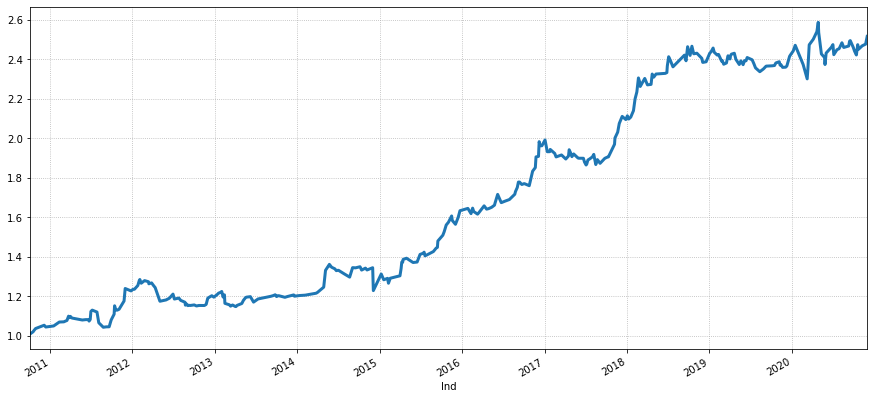

In [41]:
buy_logs_coef['100']['Return_Buy_Trades_Fees'].plot(figsize=(15,7))
#plt.savefig('../src/range_prev_day_buy_100.png')
print_stat(stat, '100_Buy_Trades_Fees')

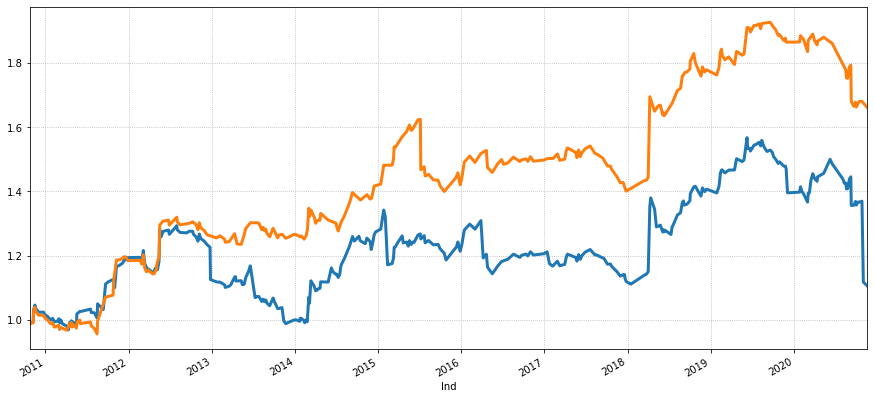

In [42]:
sell_logs_coef['100']['Return_Sell_Trades_Fees'].plot(figsize=(15,7))
sell_logs_coef['110']['Return_Sell_Trades_Fees'].plot(figsize=(15,7))
#plt.savefig('../src/range_prev_day_sell_100_110.png')
#print_stat(stat, '110_Sell_Trades_Fees')

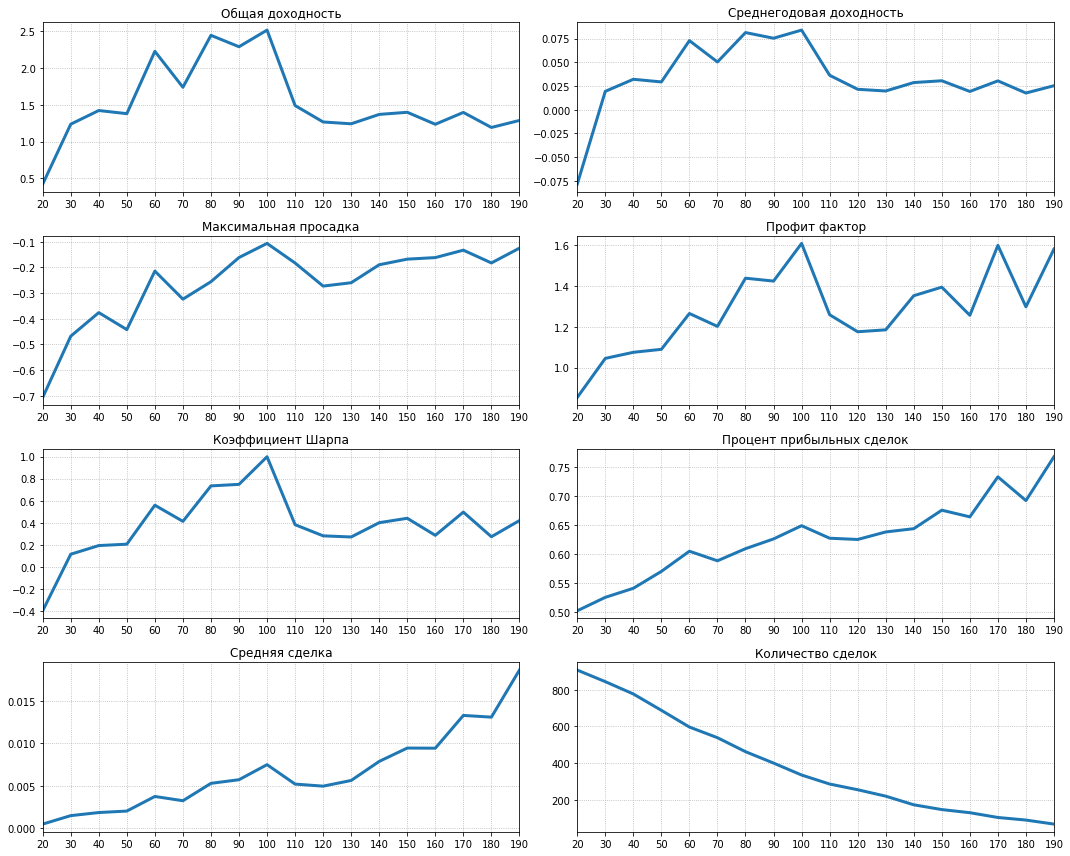

In [31]:
st = []
for coef in range(20,200,10):
    st.append(str(coef)+'_Buy_Trades_Fees')

fig, ax = plt.subplots(4,2,figsize=(15,12))
tmp = stat.loc[st]
tmp['Return_On_Account'].plot(ax=ax[0,0], xticks=range(0,len(tmp.index)), title='Общая доходность')
ax[0,0].set_xticklabels(tmp['Data'])
tmp['Avg_Year_Return'].plot(ax=ax[0,1],xticks=range(0,len(tmp.index)), title='Среднегодовая доходность')
ax[0,1].set_xticklabels(tmp['Data'])
tmp['Max_Drawdown'].plot(ax=ax[1,0],xticks=range(0,len(tmp.index)), title='Максимальная просадка')
ax[1,0].set_xticklabels(tmp['Data'])
tmp['Profit_Factor'].plot(ax=ax[1,1],xticks=range(0,len(tmp.index)), title='Профит фактор')
ax[1,1].set_xticklabels(tmp['Data'])
tmp['Sharpe_Ratio'].plot(ax=ax[2,0],xticks=range(0,len(tmp.index)), title='Коэффициент Шарпа')
ax[2,0].set_xticklabels(tmp['Data'])
tmp['Percent_Profitable'].plot(ax=ax[2,1],xticks=range(0,len(tmp.index)), title='Процент прибыльных сделок')
ax[2,1].set_xticklabels(tmp['Data'])
tmp['Avg_Trade'].plot(ax=ax[3,0],xticks=range(0,len(tmp.index)), title='Средняя сделка')
ax[3,0].set_xticklabels(tmp['Data'])
tmp['Num_Of_Trades'].plot(ax=ax[3,1],xticks=range(0,len(tmp.index)), title='Количество сделок')
ax[3,1].set_xticklabels(tmp['Data'])

fig.tight_layout()
#plt.savefig('../src/range_prev_day_buy_20_190.png')
plt.show()

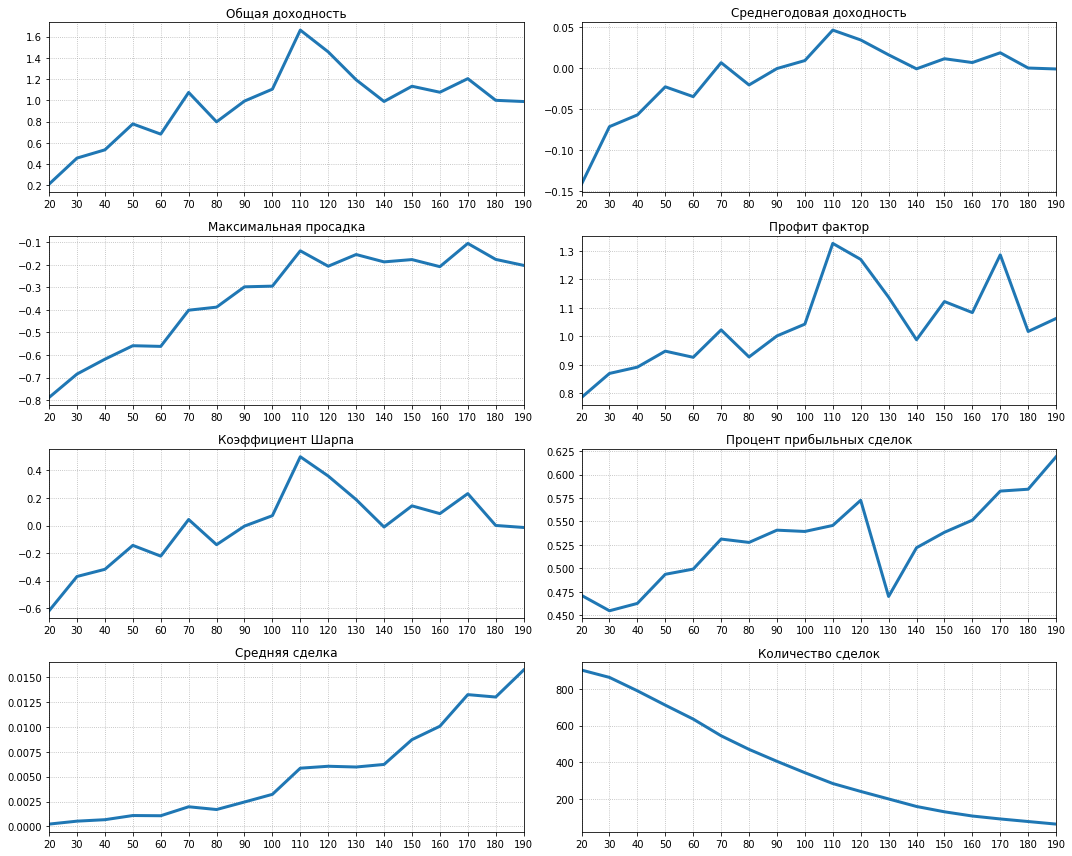

In [32]:
st = []
for coef in range(20,200,10):
    st.append(str(coef)+'_Sell_Trades_Fees')

fig, ax = plt.subplots(4,2,figsize=(15,12))
tmp = stat.loc[st]
tmp['Return_On_Account'].plot(ax=ax[0,0], xticks=range(0,len(tmp.index)), title='Общая доходность')
ax[0,0].set_xticklabels(tmp['Data'])
tmp['Avg_Year_Return'].plot(ax=ax[0,1],xticks=range(0,len(tmp.index)), title='Среднегодовая доходность')
ax[0,1].set_xticklabels(tmp['Data'])
tmp['Max_Drawdown'].plot(ax=ax[1,0],xticks=range(0,len(tmp.index)), title='Максимальная просадка')
ax[1,0].set_xticklabels(tmp['Data'])
tmp['Profit_Factor'].plot(ax=ax[1,1],xticks=range(0,len(tmp.index)), title='Профит фактор')
ax[1,1].set_xticklabels(tmp['Data'])
tmp['Sharpe_Ratio'].plot(ax=ax[2,0],xticks=range(0,len(tmp.index)), title='Коэффициент Шарпа')
ax[2,0].set_xticklabels(tmp['Data'])
tmp['Percent_Profitable'].plot(ax=ax[2,1],xticks=range(0,len(tmp.index)), title='Процент прибыльных сделок')
ax[2,1].set_xticklabels(tmp['Data'])
tmp['Avg_Trade'].plot(ax=ax[3,0],xticks=range(0,len(tmp.index)), title='Средняя сделка')
ax[3,0].set_xticklabels(tmp['Data'])
tmp['Num_Of_Trades'].plot(ax=ax[3,1],xticks=range(0,len(tmp.index)), title='Количество сделок')
ax[3,1].set_xticklabels(tmp['Data'])

fig.tight_layout()
#plt.savefig('../src/range_prev_day_sell_20_190.png')
plt.show()